In [1]:
import numpy as np
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt 
import matplotlib.ticker as tkr
%matplotlib inline

import random
seed = 666
random.seed(seed)

from mne.viz import circular_layout
from mne_connectivity.viz import plot_connectivity_circle

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

import torch
from torch import optim
import torch.utils.data as utils
from torchvision import datasets
torch.manual_seed(seed)

from inv_vae.utils.helpers import Namespace, reset_weights, min_max_standardize, preprocess_neural_data
from inv_vae.models.vae import VAE
from inv_vae.models.inv_vae import INV_VAE

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25

plt.rc('font', size=MEDIUM_SIZE)         
plt.rc('axes', titlesize=MEDIUM_SIZE)     
plt.rc('axes', labelsize=MEDIUM_SIZE) 
plt.rc('axes', linewidth = 3.)
plt.rc('xtick', labelsize=MEDIUM_SIZE)   
plt.rc('ytick', labelsize=MEDIUM_SIZE)   
plt.rc('legend', fontsize=MEDIUM_SIZE)   
plt.rc('figure', titlesize=MEDIUM_SIZE)

In [3]:
n_rois = 68
count_offset = 100
data_dir = Path("/home/yizi/inv-vae/data/hcp/")
hcp_data_dict = np.load(data_dir/"hcp_data_dict.npy", allow_pickle=True).item()
brain_networks = hcp_data_dict["network"] / count_offset
traits = hcp_data_dict["cog"][:,4] 
motion = hcp_data_dict["eddy_motion"]
# motion = np.nanmean(hcp_data_dict["rotat"], -1)
# motion = (motion - motion.mean()) / motion.std()

nan_mask = np.argwhere(~np.isnan(traits))
brain_networks = brain_networks[nan_mask]
traits = traits[nan_mask]
motion = motion[nan_mask]
n_subs = brain_networks.shape[0]

print(brain_networks.shape)
print(traits.shape)
print(motion.shape)

(1061, 1, 68, 68)
(1061, 1)
(1061, 1)


In [4]:
sub_ids = np.arange(len(brain_networks)).reshape(-1,1)
big_motion_ids = sub_ids[motion > np.quantile(motion, .9)]
small_motion_ids = sub_ids[motion < np.quantile(motion, .1)]

In [5]:
big_motion = motion[big_motion_ids].reshape(-1,1)
small_motion = motion[small_motion_ids].reshape(-1,1)

In [6]:
big_motion_nets = brain_networks[big_motion_ids].reshape(-1,n_rois*n_rois)
small_motion_nets = brain_networks[small_motion_ids].reshape(-1,n_rois*n_rois)
diff_motion_nets = big_motion_nets.mean(0) - small_motion_nets.mean(0)

In [7]:
pca = PCA(2)
obs_motion_Xt = pca.fit_transform(np.vstack([big_motion_nets, small_motion_nets]))
obs_motion_df = pd.DataFrame({"pc1": obs_motion_Xt[:,0], 
                       "pc2": obs_motion_Xt[:,1], 
                       "motion": np.vstack([big_motion, small_motion]).flatten()})

In [8]:
config = Namespace(n_nodes=n_rois, latent_dim=68, hidden_dim=1024, nuisance_dim=0,
    n_enc_layers=1, n_dec_layers=3, n_neighbors=32, drop_out=0.,
    beta = .01, add_reg = True, y_dim = 1, 
    batch_size=32, n_epochs=500, lr=5e-6, device=DEVICE)

In [9]:
A_mat = np.mean(brain_networks.reshape(-1,n_rois,n_rois), axis=0)
A_mat = A_mat + A_mat.transpose()
knn_masks = [torch.from_numpy(np.float32(np.argsort(np.argsort(A_mat, axis=-1), axis=-1) < config.n_neighbors+i)).float() for i in range(config.n_dec_layers)]

In [10]:
ids = list(range(n_subs))
random.shuffle(ids)
train_ids = ids[:int(.9*n_subs)]
val_ids = ids[int(.9*n_subs):]
print(len(train_ids), len(val_ids))

tensor_nets = torch.stack([torch.Tensor(i) for i in list(brain_networks)]).to(torch.float32).view(-1, config.n_nodes*config.n_nodes)
tensor_motion = torch.from_numpy(motion).to(torch.float32)
tensor_traits = torch.from_numpy(traits).to(torch.float32) # oral reading recognition score

train_set = utils.TensorDataset(tensor_nets[train_ids], tensor_motion[train_ids], tensor_traits[train_ids] )
val_set = utils.TensorDataset(tensor_nets[val_ids], tensor_motion[val_ids],  tensor_traits[val_ids])

train_loader = utils.DataLoader(train_set, config.batch_size) 
val_loader = utils.DataLoader(val_set, config.batch_size)

954 107


vae

In [11]:
model = VAE(config).to(config.device)
model.apply(reset_weights)
model.set_mask(knn_masks)
optimizer = optim.Adam(model.parameters(), lr=config.lr) 

In [12]:
train_losses = []
val_losses = []
for epoch in range(config.n_epochs):
    train_loss = model.reg_train(epoch, train_loader, model, optimizer, config.device, n_epoch_display=5)
    val_loss = model.reg_test(epoch, val_loader, model, config.device, n_epoch_display=5)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
train_losses = np.array(train_losses)
val_losses = np.array(val_losses)

epoch: 0 train loss: 12637.070 nll: 1909.761 kl: 345.747 rmse: 18.348
epoch: 0 test loss: 7560.392 nll: -2149.419 kl: 425.493 rmse: 18.637
epoch: 5 train loss: -13939.623 nll: -16222.614 kl: 6366.404 rmse: 8.317
epoch: 5 test loss: -15010.108 nll: -16707.759 kl: 7681.587 rmse: 7.580
epoch: 10 train loss: -16408.413 nll: -16870.051 kl: 15405.062 rmse: 3.093
epoch: 10 test loss: -16635.625 nll: -17108.367 kl: 15938.792 rmse: 3.319
epoch: 15 train loss: -16467.505 nll: -16915.380 kl: 16001.858 rmse: 2.989
epoch: 15 test loss: -16680.522 nll: -17151.054 kl: 16235.966 rmse: 3.298
epoch: 20 train loss: -16490.928 nll: -16934.784 kl: 15808.669 rmse: 2.979
epoch: 20 test loss: -16702.708 nll: -17170.109 kl: 16040.864 rmse: 3.292
epoch: 25 train loss: -16504.934 nll: -16944.555 kl: 15621.774 rmse: 2.966
epoch: 25 test loss: -16714.937 nll: -17179.050 kl: 15851.474 rmse: 3.286
epoch: 30 train loss: -16514.910 nll: -16950.008 kl: 15444.309 rmse: 2.952
epoch: 30 test loss: -16724.436 nll: -17185.1

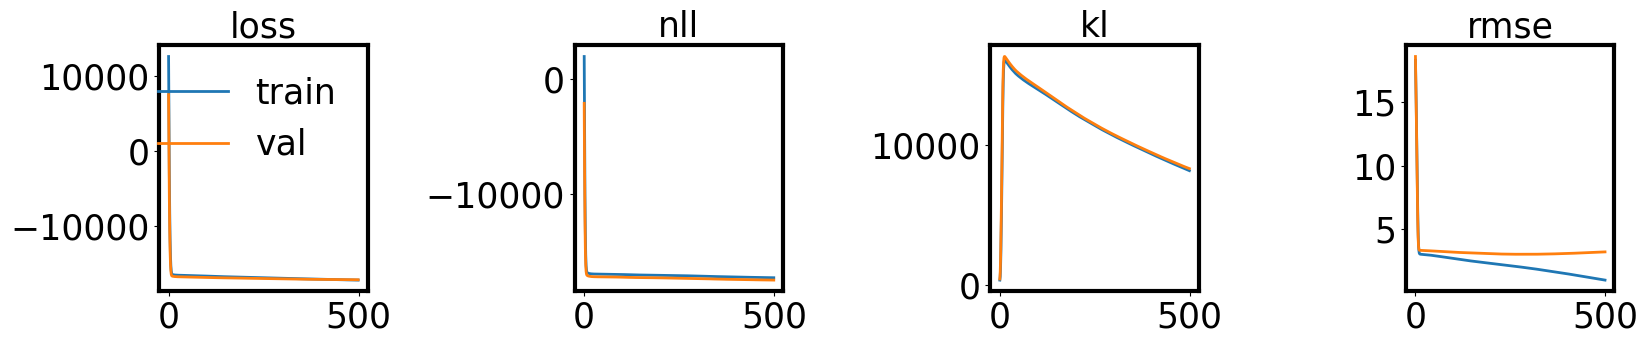

In [13]:
# diagnostics
fig, axes = plt.subplots(1, 4, figsize=(17, 4))
axes[0].plot(train_losses[:,0], linewidth=2, label='train')
axes[0].plot(val_losses[:,0], linewidth=2, label='val')
axes[0].set_title('loss')
axes[0].legend(loc=1, frameon=False)

axes[1].plot(train_losses[:,1], linewidth=2, label='train')
axes[1].plot(val_losses[:,1], linewidth=2, label='val')
axes[1].set_title('nll')

axes[2].plot(train_losses[:,2], linewidth=2, label='train')
axes[2].plot(val_losses[:,2], linewidth=2, label='val')
axes[2].set_title('kl')

axes[3].plot(train_losses[:,3], linewidth=2, label='train')
axes[3].plot(val_losses[:,3], linewidth=2, label='val')
axes[3].set_title('rmse')
plt.tight_layout()
plt.show()

In [14]:
z_mean, z_logvar = model.encode(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device))
z_sample = model.reparameterize(z_mean, z_logvar)
vae_latents = z_sample.detach().cpu().numpy()
x_recon = model.decode(z_sample).detach().cpu().numpy().reshape(-1, config.n_nodes, config.n_nodes)
x_recon = x_recon*count_offset

In [15]:
big_motion_recon = x_recon[big_motion_ids]
small_motion_recon = x_recon[small_motion_ids]
diff_motion_recon = big_motion_recon.mean(0) - small_motion_recon.mean(0)

In [16]:
big_motion_latents = vae_latents[big_motion_ids]
small_motion_latents = vae_latents[small_motion_ids]

In [17]:
pca = PCA(2)
vae_motion_Xt = pca.fit_transform(np.vstack([big_motion_latents, small_motion_latents]))
vae_motion_df = pd.DataFrame({"pc1": vae_motion_Xt[:,0], 
                       "pc2": vae_motion_Xt[:,1], 
                       "motion": np.vstack([big_motion, small_motion]).flatten()})

inv-vae

In [18]:
config = Namespace(n_nodes=68, latent_dim=68, hidden_dim=1024, nuisance_dim=1,
    n_enc_layers=1, n_dec_layers=3, n_neighbors=32, drop_out=0., 
    beta = 100., gamma = .1, add_reg = True, y_dim = 1,
    batch_size=32, n_epochs=500, lr=5e-6, device=DEVICE)

In [19]:
inv_model = INV_VAE(config).to(config.device)
inv_model.apply(reset_weights)
inv_model.set_mask(knn_masks)
optimizer = optim.Adam(inv_model.parameters(), lr=config.lr) 

In [20]:
train_losses = []
val_losses = []
for epoch in range(config.n_epochs):
    train_loss = inv_model.reg_train(epoch, train_loader, inv_model, optimizer, config.device, n_epoch_display=5)
    val_loss = inv_model.reg_test(epoch, val_loader, inv_model, config.device, n_epoch_display=5)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
train_losses = np.array(train_losses)
val_losses = np.array(val_losses)

epoch: 0 train loss: 11834.787 nll: 2379.829 kl: 168.166 inv_loss: 2.974 rmse: 18.838
epoch: 0 test loss 10794.073 nll: -810.054 kl: 201.518 inv_loss: 2.183 rmse: 19.533
epoch: 5 train loss: 3060.690 nll: -15074.691 kl: 5559.382 inv_loss: 1.149 rmse: 11.808
epoch: 5 test loss 2249.798 nll: -15860.088 kl: 7024.618 inv_loss: 1.848 rmse: 11.408
epoch: 10 train loss: -1102.496 nll: -16836.374 kl: 20402.365 inv_loss: 0.931 rmse: 3.894
epoch: 10 test loss -1065.152 nll: -17076.285 kl: 22201.137 inv_loss: 2.418 rmse: 3.739
epoch: 15 train loss: -1317.448 nll: -16897.168 kl: 26743.347 inv_loss: 0.887 rmse: 2.965
epoch: 15 test loss -1151.037 nll: -17131.753 kl: 27368.296 inv_loss: 2.570 rmse: 3.284
epoch: 20 train loss: -1330.295 nll: -16922.262 kl: 27062.131 inv_loss: 0.806 rmse: 2.953
epoch: 20 test loss -1161.057 nll: -17155.548 kl: 27600.663 inv_loss: 2.498 rmse: 3.283
epoch: 25 train loss: -1340.961 nll: -16935.144 kl: 27148.298 inv_loss: 0.732 rmse: 2.942
epoch: 25 test loss -1171.817 nl

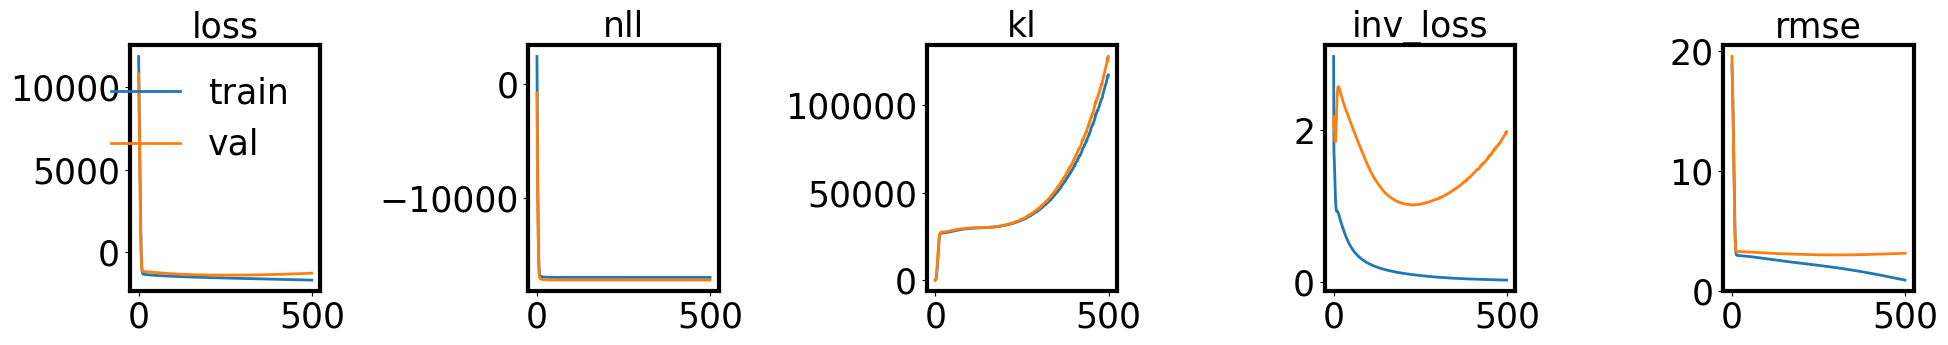

In [21]:
# diagnostics
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
axes[0].plot(train_losses[:,0], linewidth=2, label='train')
axes[0].plot(val_losses[:,0], linewidth=2, label='val')
axes[0].set_title('loss')
axes[0].legend(loc=1, frameon=False)

axes[1].plot(train_losses[:,1], linewidth=2, label='train')
axes[1].plot(val_losses[:,1], linewidth=2, label='val')
axes[1].set_title('nll')

axes[2].plot(train_losses[:,2], linewidth=2, label='train')
axes[2].plot(val_losses[:,2], linewidth=2, label='val')
axes[2].set_title('kl')

axes[3].plot(train_losses[:,3], linewidth=2, label='train')
axes[3].plot(val_losses[:,3], linewidth=2, label='val')
axes[3].set_title('inv_loss')

axes[4].plot(train_losses[:,4], linewidth=2, label='train')
axes[4].plot(val_losses[:,4], linewidth=2, label='val')
axes[4].set_title('rmse')

plt.tight_layout()
plt.show()

In [22]:
z_mean, z_logvar = inv_model.encode(tensor_nets.to(config.device))
z_sample = inv_model.reparameterize(z_mean, z_logvar)
inv_latents = z_sample.detach().cpu().numpy()

x_denoised = inv_model.decode(z_sample, 
                      torch.zeros_like(tensor_motion).to(config.device) 
                      ).detach().cpu().numpy().reshape(-1, config.n_nodes, config.n_nodes)
x_denoised = x_denoised*count_offset

In [23]:
big_motion_denoised = x_denoised[big_motion_ids]
small_motion_denoised = x_denoised[small_motion_ids]
diff_motion_denoised = big_motion_denoised.mean(0) - small_motion_denoised.mean(0)

In [24]:
big_motion_inv_latents = inv_latents[big_motion_ids]
small_motion_inv_latents = inv_latents[small_motion_ids]

In [25]:
pca = PCA(2)
inv_vae_motion_Xt = pca.fit_transform(np.vstack([big_motion_inv_latents, small_motion_inv_latents]))
inv_vae_motion_df = pd.DataFrame({"pc1": inv_vae_motion_Xt[:,0], 
                       "pc2": inv_vae_motion_Xt[:,1], 
                       "motion": np.vstack([big_motion, small_motion]).flatten()})

plotting

In [26]:
n=39
x = 0.32
cmap = plt.cm.coolwarm
lower = cmap(np.linspace(0, x-.1, n))
white = np.ones((80-2*n,4))
upper = cmap(np.linspace(1-x+.1, 1, n))
colors = np.vstack((lower, white, upper))
div_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('div_cmap', colors)

In [27]:
from matplotlib import colors
divnorm=colors.TwoSlopeNorm(vmin=np.min(motion), vcenter=np.median(motion), vmax=np.max(motion))

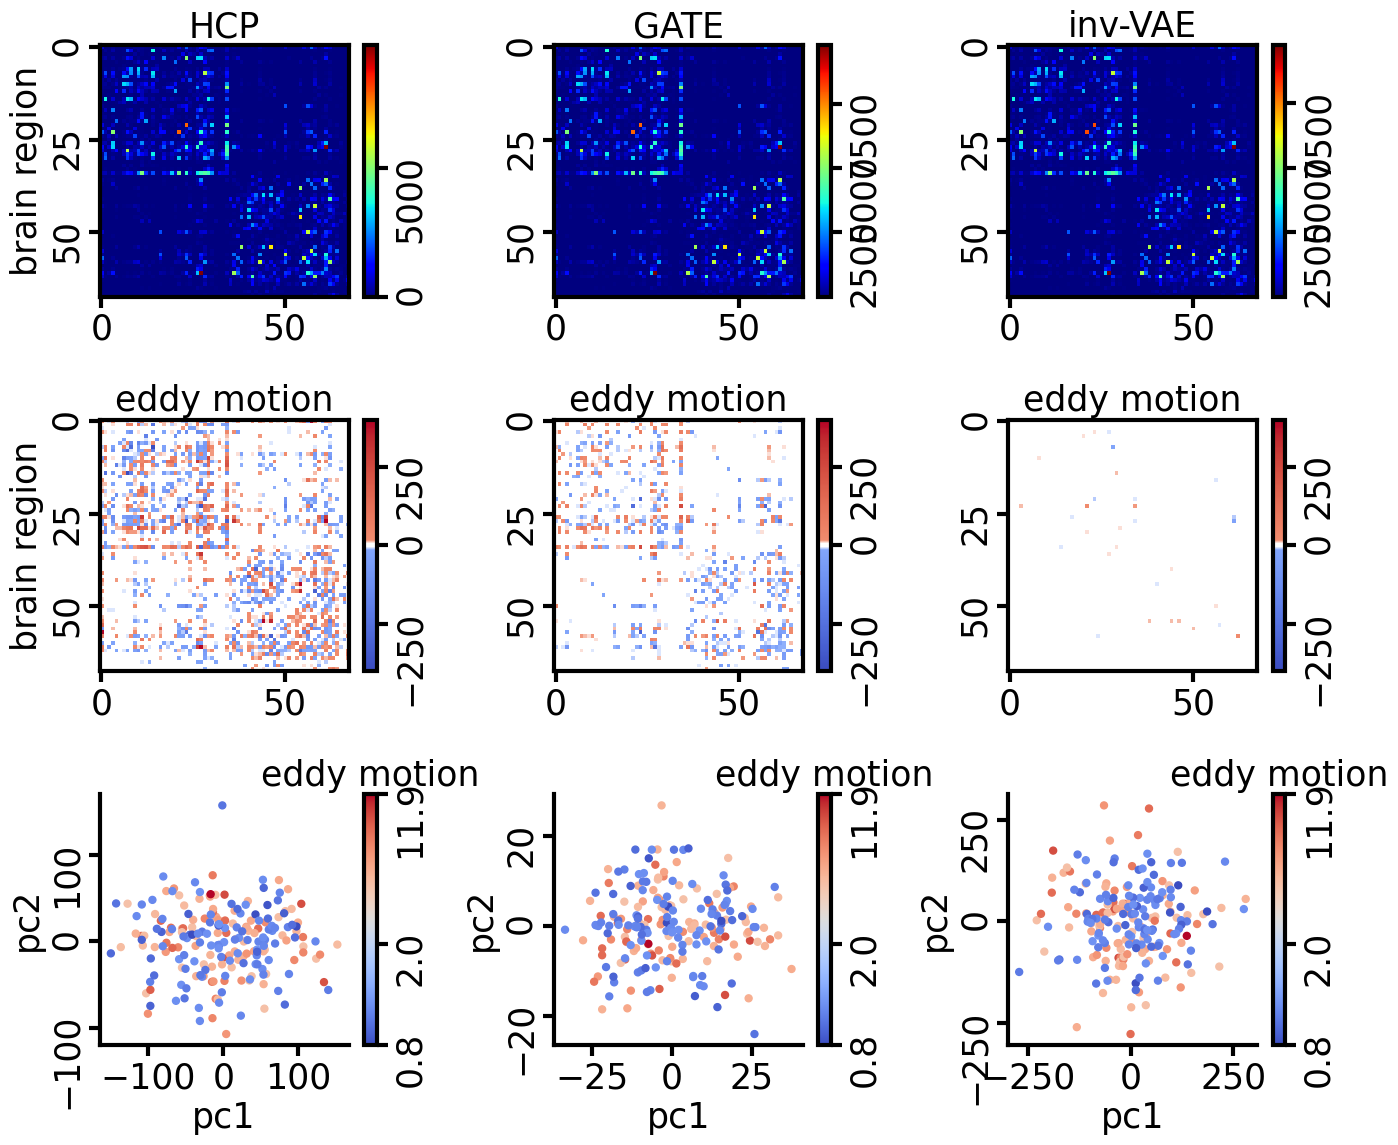

In [28]:
fig, axes = plt.subplots(3, 3, figsize=(14, 12))

p1 = axes[0,0].imshow(brain_networks.mean(0).reshape(n_rois,n_rois)*count_offset, 
                      aspect='auto', cmap='jet')
axes[0,0].set_title('HCP')
axes[0,0].set_ylabel('brain region')
axes[0,0].tick_params(axis='y', labelrotation=90, length=8, width=3)
axes[0,0].tick_params(axis='x', length=8, width=3)
cbar = plt.colorbar(p1, ax=axes[0,0])
cbar.ax.tick_params(labelrotation=90, length=8, width=3, labelbottom=False)

p2 = axes[1,0].imshow(diff_motion_nets.reshape(n_rois,n_rois)*count_offset, 
                      aspect='auto', cmap=div_cmap, vmin=-400, vmax=400)
axes[1,0].set_title('eddy motion')
axes[1,0].set_ylabel('brain region')
axes[1,0].tick_params(axis='y', labelrotation=90, length=8, width=3)
axes[1,0].tick_params(axis='x', length=8, width=3)
cbar = plt.colorbar(p2, ax=axes[1,0])
cbar.ax.tick_params(labelrotation=90, length=8, width=3, labelbottom=False)
# cbar.set_ticks([-250, 0, 250])

p3 = axes[2,0].scatter(x="pc1", y="pc2", c="motion", cmap="coolwarm", norm=divnorm,
                       data=obs_motion_df, s=25, alpha=1.)
axes[2,0].set_xlabel('pc1')
axes[2,0].set_ylabel('pc2')
axes[2,0].spines['top'].set_visible(False)
axes[2,0].spines['right'].set_visible(False)
axes[2,0].tick_params(axis='y', labelrotation=90, length=8, width=3)
axes[2,0].tick_params(axis='x', length=8, width=3)
cbar = plt.colorbar(p3, ax=axes[2,0])
cbar.ax.set_title('eddy motion')
# cbar.ax.set_title('rotation')
cbar.ax.tick_params(labelrotation=90, length=8, width=3, labelbottom=False)
cbar.set_ticks([np.min(motion), 2., np.max(motion)])
cbar.ax.yaxis.set_major_formatter(tkr.FormatStrFormatter('%.1f'))
# axes[2,0].set_xlim(-100, 100)
# axes[2,0].set_ylim(-100, 100)


p4 = axes[0,1].imshow(x_recon.mean(0), aspect='auto', cmap='jet')
axes[0,1].set_title('GATE')
axes[0,1].tick_params(axis='y', labelrotation=90, length=8, width=3)
axes[0,1].tick_params(axis='x', length=8, width=3)
cbar = plt.colorbar(p4, ax=axes[0,1])
cbar.ax.tick_params(labelrotation=90, length=8, width=3, labelbottom=False)
cbar.ax.tick_params(labelrotation=90, length=8, width=3, labelbottom=False)


p5 = axes[1,1].imshow(diff_motion_recon, aspect='auto', cmap=div_cmap, vmin=-400, vmax=400)
axes[1,1].set_title('eddy motion')
axes[1,1].tick_params(axis='y', labelrotation=90, length=8, width=3)
axes[1,1].tick_params(axis='x', length=8, width=3)
cbar = plt.colorbar(p5, ax=axes[1,1])
cbar.ax.tick_params(labelrotation=90, length=8, width=3, labelbottom=False)
# cbar.set_ticks([-250, 0, 250])


p6 = axes[2,1].scatter(x="pc1", y="pc2", c="motion", cmap="coolwarm", norm=divnorm, 
                       data=vae_motion_df, s=25, alpha=1.)
axes[2,1].set_xlabel('pc1')
axes[2,1].set_ylabel('pc2')
axes[2,1].spines['top'].set_visible(False)
axes[2,1].spines['right'].set_visible(False)
axes[2,1].tick_params(axis='y', labelrotation=90, length=8, width=3)
axes[2,1].tick_params(axis='x', length=8, width=3)
cbar = plt.colorbar(p6, ax=axes[2,1])
cbar.ax.set_title('eddy motion')
# cbar.ax.set_title('rotation')
cbar.ax.tick_params(labelrotation=90, length=8, width=3, labelbottom=False)
cbar.set_ticks([np.min(motion), 2., np.max(motion)])
cbar.ax.yaxis.set_major_formatter(tkr.FormatStrFormatter('%.1f'))
# axes[2,1].set_ylim(-10, 10)


p7 = axes[0,2].imshow(x_denoised.mean(0), aspect='auto', cmap='jet')
axes[0,2].set_title('inv-VAE')
axes[0,2].tick_params(axis='y', labelrotation=90, length=8, width=3)
axes[0,2].tick_params(axis='x', length=8, width=3)
axes[0,2].tick_params(axis='y', labelrotation=90, length=8, width=3)
axes[0,2].tick_params(axis='x', length=8, width=3)
cbar = plt.colorbar(p7, ax=axes[0,2])
cbar.ax.tick_params(labelrotation=90, length=8, width=3, labelbottom=False)

p8 = axes[1,2].imshow(diff_motion_denoised, aspect='auto', cmap=div_cmap, vmin=-400, vmax=400)
axes[1,2].set_title('eddy motion')
axes[1,2].tick_params(axis='y', labelrotation=90, length=8, width=3)
axes[1,2].tick_params(axis='x', length=8, width=3)
cbar = plt.colorbar(p8, ax=axes[1,2])
cbar.ax.tick_params(labelrotation=90, length=8, width=3, labelbottom=False)
# cbar.set_ticks([-250, 0, 250])


p9 = axes[2,2].scatter(x="pc1", y="pc2", c="motion", cmap="coolwarm", norm=divnorm, 
                       data=inv_vae_motion_df, s=25, alpha=1.)
axes[2,2].set_xlabel('pc1')
axes[2,2].set_ylabel('pc2')
axes[2,2].spines['top'].set_visible(False)
axes[2,2].spines['right'].set_visible(False)
axes[2,2].tick_params(axis='y', labelrotation=90, length=8, width=3)
axes[2,2].tick_params(axis='x', length=8, width=3)
cbar = plt.colorbar(p9, ax=axes[2,2])
cbar.ax.set_title('eddy motion')
# cbar.ax.set_title('rotation')
cbar.ax.tick_params(labelrotation=90, length=8, width=3, labelbottom=False)
cbar.set_ticks([np.min(motion), 2., np.max(motion)])
cbar.ax.yaxis.set_major_formatter(tkr.FormatStrFormatter('%.1f'))
# axes[2,2].set_xlim(-100, 100)

plt.tight_layout()
# plt.savefig('../saved_figs/fig5_hcp_correct_motion.png', facecolor='white', dpi=800)

circular connectivity plots:

unfortunately, i am having trouble with plotting multiple circular connectivity plots using mne,\
so i have to plot each circ plot separately :(

In [29]:
cmap = plt.cm.tab20c

labels = {
    'bankssts': cmap(0),
    'caudalanteriorcingulate': cmap(1),
    'caudalmiddlefrontal': cmap(1),
    'cuneus': cmap(2),
    'entorhinal': cmap(3),
    'fusiform': cmap(4),
    'inferiorparietal': cmap(5),
    'inferiortemporal': cmap(5),
    'isthmuscingulate': cmap(6),
    'lateraloccipital': cmap(7),
    'lateralorbitofrontal': cmap(7),
    'lingual': cmap(8),
    'medialorbitofrontal': cmap(9),
    'middletemporal': cmap(10),
    'parahippocampal': cmap(11),
    'paracentral': cmap(11),
    'parsopercularis': cmap(11),
    'parsorbitalis': cmap(11),
    'parstriangularis': cmap(11),
    'pericalcarine': cmap(12),
    'postcentral': cmap(13),
    'posteriorcingulate': cmap(13),
    'precentral': cmap(14),
    'precuneus': cmap(14),
    'rostralanteriorcingulate': cmap(15),
    'rostralmiddlefrontal': cmap(15),
    'superiorfrontal': cmap(16),
    'superiorparietal': cmap(16),
    'superiortemporal': cmap(16),
    'supramarginal': cmap(16),
    'frontalpole': cmap(16),
    'temporalpole': cmap(17),
    'transversetemporal': cmap(18),
    'insula': cmap(19)
}

label_colors = list()
label_colors.extend(list(labels.values())[::-1])  
label_colors.extend(list(labels.values()))

lh_labels = ['lh-' + label for label in labels.keys()]
rh_labels = ['rh-' + label for label in labels.keys()]

node_order = list()
node_order.extend(lh_labels[::-1])  
node_order.extend(rh_labels)

node_angles = circular_layout(node_order, node_order, start_pos=90,
                              group_boundaries=[0, len(node_order) / 2])

In [30]:
diff_motion_adjusted = x_denoised.mean(0).flatten() - brain_networks.mean(0).reshape(-1,n_rois*n_rois)

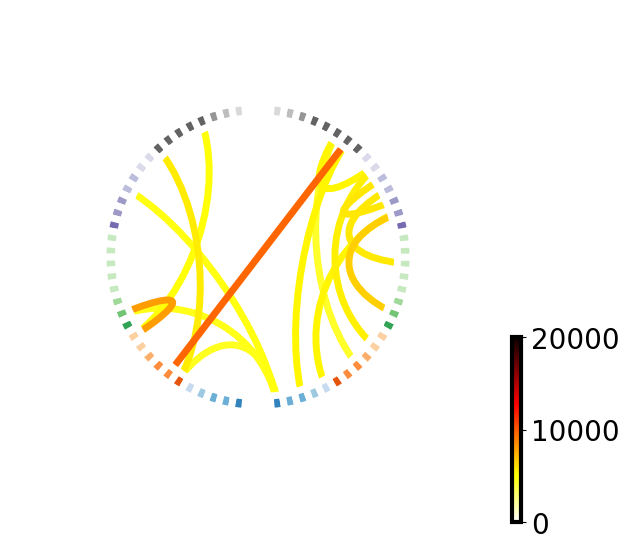

In [31]:
fig, ax = plt.subplots(figsize=(8, 8), facecolor='white',
                       subplot_kw=dict(polar=True))
fig, ax = plot_connectivity_circle(
                         diff_motion_adjusted.reshape(n_rois,n_rois), 
                         node_angles=node_angles,
                         node_colors=label_colors,
                         facecolor='white',
                         textcolor='black', 
                         node_edgecolor='white',
                         colormap='hot_r',
                         node_height=1.,
                         node_linewidth=5.,
                         vmin=0,
                         vmax=20000,
                         node_names=['' for i in range(n_rois)], 
                         colorbar=True,
                         colorbar_size=.3,
                         fontsize_colorbar=20,
                         linewidth=5,
                         n_lines=15, ax=ax)
fig.tight_layout()
# fig.savefig('../saved_figs/fig6_hcp_motion_adjusted.png', facecolor='white', dpi=400)